# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import os
import hashlib
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import copy
from tqdm import tqdm

# Data Preprocessing and Visualization: Places365

Places365 is located in /datasets-2/places365/places365_standard/train 

In this directory, there are a number of subdirectories for each class. Within each subdirectory are jpgs of the actual images comprising the dataset. 

In order to use this large dataset on DSMLP and get around the disk quota of 10GB per user, we have to create a custom dataloader and dataset. This is because of our requirements of the dataset: divide the train data into training, validation, and testing datasets, and apply masking to the individual images so that they can be fed into the context encoder.

In [2]:
class Places365Dataset(Dataset):
    def __init__(self, root, file_list, transform=None):
        self.root = root
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        label = img_name.split('/')[5]

        original = image

        if self.transform:
            original = self.transform(original)
        
        masked, true_center = self.mask_center_region(original)
        
        return masked, true_center, original, label
    
    def mask_center_region(self, image):
#         width, height = image.size
#         #fill = np.mean(np.asarray(image), axis=(0, 1))
        
#         square_size = min(height, width) // 3 
#         start_x = (width - square_size) // 2
#         end_x = start_x + square_size
#         start_y = (height - square_size) // 2
#         end_y = start_y + square_size
        
#         #mask = np.full((width, height, 3), 255, dtype = np.uint8)
#         #cv2.rectangle(mask, (start_x, start_y), (end_x, end_y), fill, -1)

#         masked_image = np.asarray(image).copy()
#         masked_image[start_y:end_y, start_x:end_x, 0] = 117.0
#         masked_image[start_y:end_y, start_x:end_x, 1] = 104.0
#         masked_image[start_y:end_y, start_x:end_x, 2] = 123.0
#         true_center = np.asarray(image)[start_y:end_y, start_x:end_x]
#         return masked_image, true_center
        masked_image = image[:].clone()
        masked_image[0, 32+4:96-4, 32+4:96-4] = 2*117.0/255.0 - 1.0
        masked_image[1, 32+4:96-4, 32+4:96-4] = 2*104.0/255.0 - 1.0
        masked_image[2, 32+4:96-4, 32+4:96-4] = 2*123.0/255.0 - 1.0
        true_center = image[:, 32:96, 32:96]
        
        return masked_image, true_center

In [3]:
dataset_root = '/datasets-2/places365/places365_standard'
train_txt_file = os.path.join(dataset_root, 'train.txt')

# Open the text file in read mode
with open(train_txt_file, 'r') as file:
    num_lines = sum(1 for line in file)

print("Number of image names in the train.txt:", num_lines)

# Read the content of train.txt and val.txt files
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

train_files = read_file(train_txt_file)

# Shuffle the filenames to randomize the order
random.shuffle(train_files)

# Split the dataset into training and testing subsets
train_split_ratio = 0.7
val_split_ratio = 0.2
test_split_ratio = 0.1
num_train_samples = int(len(train_files) * train_split_ratio)
num_val_samples = int(len(train_files) * val_split_ratio)
num_test_samples = int(len(train_files) * test_split_ratio)
train_subset = train_files[:num_train_samples]
val_subset = train_files[num_train_samples:(num_train_samples+num_val_samples)]
test_subset = train_files[(num_train_samples+num_val_samples):]

# Define transformations for data preprocessing
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128), antialias=True),
])

# Create train, val, test datasets
batch_size= 64

train_dataset = Places365Dataset(dataset_root, train_subset, transform=train_transform)
val_dataset = Places365Dataset(dataset_root, val_subset, transform=train_transform)
test_dataset = Places365Dataset(dataset_root, test_subset, transform=train_transform)

places365_train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
places365_val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
places365_test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

print("Number of images in the places365_train_loader:", len(places365_train_loader) * batch_size)
print("Number of images in the places365_val_loader:", len(places365_val_loader) * batch_size)

Number of image names in the train.txt: 1803460
Number of images in the places365_train_loader: 1262464
Number of images in the places365_val_loader: 360704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 128, 128])
Masked Image


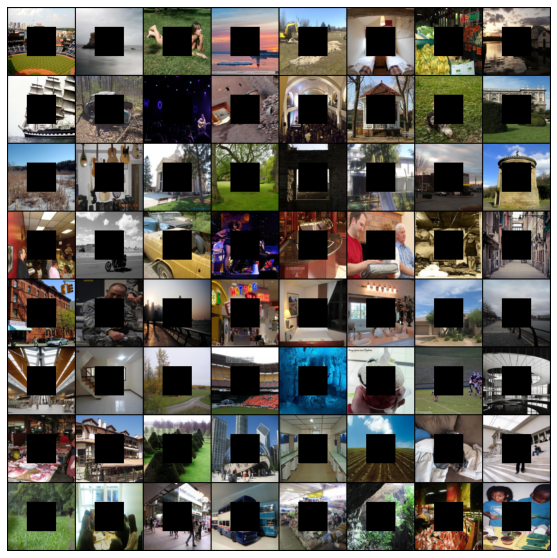

True Center


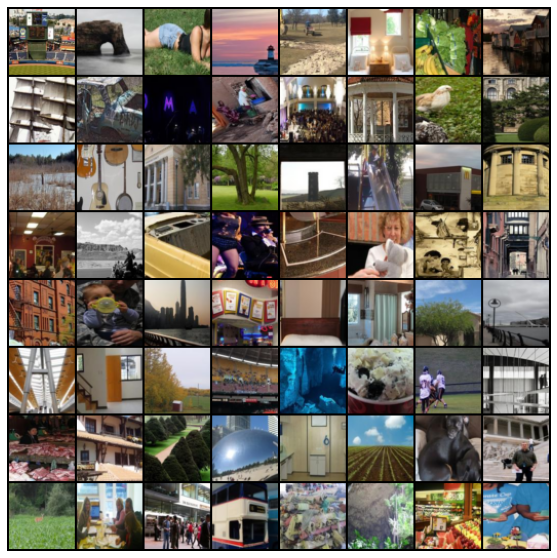

Original Image


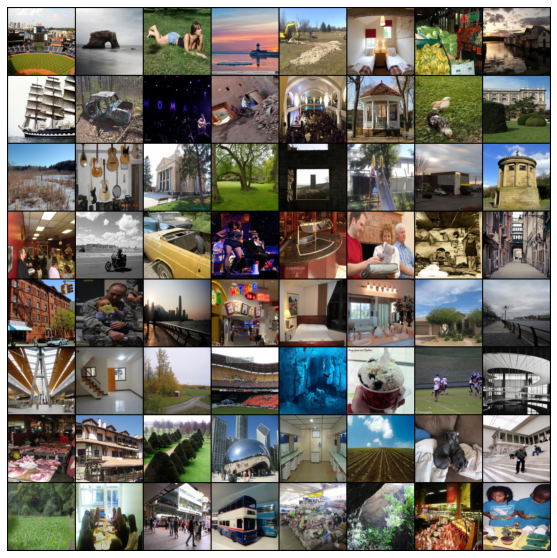

Image Name ('stadium-baseball', 'rock_arch', 'lawn', 'lighthouse', 'excavation', 'youth_hostel', 'market-indoor', 'boathouse', 'harbor', 'junkyard', 'stage-indoor', 'kasbah', 'mezzanine', 'gazebo-exterior', 'tundra', 'topiary_garden', 'marsh', 'repair_shop', 'courthouse', 'lawn', 'ruin', 'playground', 'fastfood_restaurant', 'mausoleum', 'ice_cream_parlor', 'badlands', 'junkyard', 'arena-performance', 'restaurant_kitchen', 'nursing_home', 'slum', 'alley', 'balcony-exterior', 'army_base', 'boardwalk', 'fastfood_restaurant', 'hotel_room', 'bathroom', 'formal_garden', 'promenade', 'shopping_mall-indoor', 'artists_loft', 'field_road', 'stadium-soccer', 'grotto', 'ice_cream_parlor', 'stadium-football', 'atrium-public', 'butchers_shop', 'balcony-exterior', 'topiary_garden', 'museum-outdoor', 'office_cubicles', 'field-cultivated', 'veterinarians_office', 'palace', 'corn_field', 'computer_room', 'atrium-public', 'subway_station-platform', 'fabric_store', 'rainforest', 'department_store', 'art_s

In [4]:
masked, true_center, original, image_name = next(iter(places365_train_loader))
print(masked.shape, true_center.shape, original.shape)

def display_samples(image):
    npimg = image.numpy()
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

print('Masked Image')
display_samples(torchvision.utils.make_grid(masked))
print('True Center')
display_samples(torchvision.utils.make_grid(true_center))
print('Original Image')
display_samples(torchvision.utils.make_grid(original))
print('Image Name', image_name)

# Context Encoder Architecture

In [5]:
class ContextEncoder(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(ContextEncoder, self).__init__()
        
        #My code
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        #self.conv_bottleneck = nn.Conv2d(512, bottleneck_channels, kernel_size=4, stride=1, padding=0)
        
        self.conv_bottleneck = nn.Sequential(
            nn.Conv2d(512, bottleneck_channels, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(bottleneck_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv_bottleneck(x)
        return x

In [6]:
class ContextDecoder(nn.Module):
    def __init__(self, bottleneck_channels=2048, out_channels=3):
        super(ContextDecoder, self).__init__()
        
        #My code
        self.transpose_conv1 = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_channels, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv5 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.transpose_conv1(x)
        x = self.transpose_conv2(x)
        x = self.transpose_conv3(x)
        x = self.transpose_conv4(x)
        x = self.transpose_conv5(x)
        x = self.tanh(x)
        return x

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(Generator, self).__init__()
        
        self.context_encoder = ContextEncoder(in_channels=in_channels, bottleneck_channels=bottleneck_channels)
        
        self.context_decoder = ContextDecoder(bottleneck_channels=bottleneck_channels, out_channels=in_channels)
        
    def forward(self, x):
        encoder_output = self.context_encoder(x)
        decoder_output = self.context_decoder(encoder_output)
        return decoder_output
        

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

# Training

In [9]:
def store_weights(generator, discriminator, root = "./weights/"):
    if not os.path.exists(root):
        os.makedirs(root)
    torch.save(generator.state_dict(), root + "generator")
    torch.save(discriminator.state_dict(), root + "discriminator")

def load_models(root = "./weights/"):
    generator = Generator(in_channels=3, bottleneck_channels=2048)
    discriminator = Discriminator(in_channels=3)
    
    if os.path.exists(root):
        generator.load_state_dict(torch.load(root + "generator"))
        discriminator.load_state_dict(torch.load(root + "discriminator"))
    
    return generator, discriminator

In [11]:
def train(generator, discriminator, epochs, batch_size, learning_rate, betas, train_loader):  
    
    generator.to(device)
    discriminator.to(device)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    
    loss_func_BCE = nn.BCELoss()
    #loss_func_MSE = nn.MSELoss()
    
    loss_func_BCE.to(device)
    #loss_func_MSE.to(device)
    
    #Set learning rates for our total loss
    weight_reconstruction = 0.999
    weight_adversarial = 0.001
    
    for i in range(epochs):
        
        total_loss = 0.0
        num_samples = 0
        start_time = time.time()
        
        generator.zero_grad()
        generator.train()
        discriminator.zero_grad()
        discriminator.train()
        
        for batch_idx, (masked, true_center, original, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
            masked, true_center, original = masked.to(device), true_center.to(device), original.to(device)
            curr_batch_size = masked.size(0)
            real_labels = torch.ones((curr_batch_size, 1, 1, 1)).to(device)
            fake_labels = torch.zeros((curr_batch_size, 1, 1, 1)).to(device)
            
            #Discriminator
            optimizer_D.zero_grad()
            
            #Train with real
            discriminator_real_output = discriminator(true_center)
            discriminator_real_loss = loss_func_BCE(discriminator_real_output, real_labels)
            
            #Train with fake
            generator_output = generator(masked)
            discriminator_fake_output = discriminator(generator_output.detach())
            discriminator_fake_loss = loss_func_BCE(discriminator_fake_output, fake_labels)
            
            discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
            discriminator_total_loss.backward()
            optimizer_D.step()
            
            #Adversarial Loss
            discriminator_fake_output = discriminator(generator_output)
            adversarial_loss = loss_func_BCE(discriminator_fake_output, real_labels)
            
            #Generator
            optimizer_G.zero_grad()
            
            loss_weights = torch.ones(generator_output.size()).to(device)
            
            #reconstruction_loss = loss_func_MSE(fake, true_center, loss_weights)
            reconstruction_loss = torch.mean(loss_weights * (generator_output - true_center).pow(2))
            generator_total_loss = weight_reconstruction * reconstruction_loss + weight_adversarial * adversarial_loss

            generator_total_loss.backward()
            optimizer_G.step()
            
            #Metrics / Save weights every 2000 batches
            
            total_loss += generator_total_loss.item() * curr_batch_size
            num_samples += curr_batch_size
            
            if batch_idx % 1999 == 0:
                store_weights(generator, discriminator, root = "./weights/")
                
                correct_real = (discriminator_real_output > 0.5).sum().item()
                correct_fake = (discriminator_fake_output <= 0.5).sum().item()
                total_real = real_labels.size(0)
                total_fake = fake_labels.size(0)

                accuracy_real = correct_real / total_real
                accuracy_fake = correct_fake / total_fake

                end_time = time.time()
                execution_time = end_time - start_time
                print('Batch %d | Epoch Loss: %.4f | D(Real) Acc.: %.4f | D(Fake) Acc.: %.4f | Execution Time: %.4f' 
                      % (batch_idx+1, total_loss/num_samples, accuracy_real, accuracy_fake, execution_time))
            
        store_weights(generator, discriminator, root = "./weights/")
        end_time = time.time()
        execution_time = end_time - start_time
        print('Epoch %d | Context-Encoder Loss: %.4f | Execution Time: %.4f' % (i+1, total_loss/num_samples, execution_time))
    
    

In [12]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Using device ", device)

epochs = 1
learning_rate = 0.0002
betas = (0.5, 0.999)

generator, discriminator = load_models()
train(generator=generator, discriminator=discriminator, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, betas=betas, train_loader=places365_train_loader)

Using device  cuda


  0%|          | 2/19726 [00:02<5:51:19,  1.07s/it] 

Batch 1 | Epoch Loss: 0.0418 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 2.4887


 10%|█         | 2001/19726 [04:47<1:09:57,  4.22it/s]

Batch 2000 | Epoch Loss: 0.0389 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 287.2908


 20%|██        | 4000/19726 [09:29<1:02:26,  4.20it/s]

Batch 3999 | Epoch Loss: 0.0387 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 568.9857


 30%|███       | 5999/19726 [14:07<53:19,  4.29it/s]  

Batch 5998 | Epoch Loss: 0.0386 | D(Real) Acc.: 0.9375 | D(Fake) Acc.: 1.0000 | Execution Time: 847.3908


 41%|████      | 7998/19726 [18:47<49:17,  3.97it/s]

Batch 7997 | Epoch Loss: 0.0386 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 1127.2918


 51%|█████     | 9997/19726 [23:24<39:59,  4.05it/s]

Batch 9996 | Epoch Loss: 0.0385 | D(Real) Acc.: 0.4219 | D(Fake) Acc.: 0.2812 | Execution Time: 1404.4970


 61%|██████    | 11996/19726 [27:57<30:58,  4.16it/s]

Batch 11995 | Epoch Loss: 0.0384 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 1677.1447


 71%|███████   | 13995/19726 [32:29<22:22,  4.27it/s]

Batch 13994 | Epoch Loss: 0.0384 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 1949.4161


 81%|████████  | 15994/19726 [37:09<15:17,  4.07it/s]  

Batch 15993 | Epoch Loss: 0.0384 | D(Real) Acc.: 0.5156 | D(Fake) Acc.: 0.9844 | Execution Time: 2229.7304


 91%|█████████ | 17993/19726 [41:53<07:16,  3.97it/s]

Batch 17992 | Epoch Loss: 0.0384 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 2513.0649


100%|██████████| 19726/19726 [45:53<00:00,  7.17it/s]


Epoch 1 | Context-Encoder Loss: 0.0384 | Execution Time: 2753.6274


# Sid's Train with Learning rate scheduler

In [16]:
def train(generator, discriminator, epochs, batch_size, learning_rate_G, learning_rate_D, betas, train_loader):  
    
    generator.to(device)
    discriminator.to(device)
    
    # Different learning rates for generator and discriminator
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D, betas=betas)
    
    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
    scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)
    
    loss_func_BCE = nn.BCELoss()
    loss_func_BCE.to(device)
    
    # Set learning rates for our total loss
    weight_reconstruction = 0.999
    weight_adversarial = 0.001
    
    for epoch in range(epochs):
        
        total_loss = 0.0
        num_samples = 0
        start_time = time.time()
        
        for batch_idx, (masked, true_center, original, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
            masked, true_center, original = masked.to(device), true_center.to(device), original.to(device)
            curr_batch_size = masked.size(0)
            real_labels = torch.ones((curr_batch_size, 1, 1, 1)).to(device)
            fake_labels = torch.zeros((curr_batch_size, 1, 1, 1)).to(device)
            
            # Train Discriminator with real
            optimizer_D.zero_grad()
            discriminator_real_output = discriminator(true_center)
            discriminator_real_loss = loss_func_BCE(discriminator_real_output, real_labels)
            
            # Train Discriminator with fake
            generator_output = generator(masked)
            discriminator_fake_output = discriminator(generator_output.detach())
            discriminator_fake_loss = loss_func_BCE(discriminator_fake_output, fake_labels)
            discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
            discriminator_total_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            discriminator_fake_output_for_gen = discriminator(generator_output)
            adversarial_loss = loss_func_BCE(discriminator_fake_output_for_gen, real_labels)
            loss_weights = torch.ones(generator_output.size()).to(device)
            reconstruction_loss = torch.mean(loss_weights * (generator_output - true_center).pow(2))
            generator_total_loss = weight_reconstruction * reconstruction_loss + weight_adversarial * adversarial_loss
            generator_total_loss.backward()
            optimizer_G.step()
            
            # Metrics / Save weights every 2000 batches
            total_loss += generator_total_loss.item() * curr_batch_size
            num_samples += curr_batch_size
            
            if batch_idx % 1999 == 0:
                store_weights(generator, discriminator, root = "./weights/")
                print_metrics(batch_idx, total_loss, num_samples, start_time, discriminator_real_output, discriminator_fake_output)

        # Step the learning rate schedulers
        scheduler_G.step()
        scheduler_D.step()
        
        print_epoch_summary(epoch, total_loss, num_samples, start_time)

In [17]:
def print_metrics(batch_idx, total_loss, num_samples, start_time, discriminator_real_output, discriminator_fake_output):
    correct_real = (discriminator_real_output > 0.5).sum().item()
    correct_fake = (discriminator_fake_output <= 0.5).sum().item()
    total_real = discriminator_real_output.size(0)
    total_fake = discriminator_fake_output.size(0)
    accuracy_real = correct_real / total_real
    accuracy_fake = correct_fake / total_fake
    execution_time = time.time() - start_time
    print('Batch %d | Epoch Loss: %.4f | D(Real) Acc.: %.4f | D(Fake) Acc.: %.4f | Execution Time: %.4f' 
          % (batch_idx + 1, total_loss / num_samples, accuracy_real, accuracy_fake, execution_time))

In [18]:
def print_epoch_summary(epoch, total_loss, num_samples, start_time):
    execution_time = time.time() - start_time
    print('Epoch %d | Context-Encoder Loss: %.4f | Execution Time: %.4f' % (epoch + 1, total_loss / num_samples, execution_time))

In [20]:
learning_rate_G = 0.0008  # Generator learning rate
learning_rate_D = 0.0001  # Discriminator learning rate
epochs = 1
betas = (0.5, 0.999)

generator, discriminator = load_models()
train(generator=generator, discriminator=discriminator, epochs=epochs, batch_size=64, learning_rate_G=learning_rate_G, learning_rate_D=learning_rate_D, betas=betas, train_loader=places365_train_loader)

  0%|          | 2/19726 [00:01<2:25:49,  2.25it/s]

Batch 1 | Epoch Loss: 0.0415 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 0.9652


 10%|█         | 2001/19726 [04:14<1:07:30,  4.38it/s]

Batch 2000 | Epoch Loss: 0.0403 | D(Real) Acc.: 0.9688 | D(Fake) Acc.: 0.8438 | Execution Time: 254.7883


 20%|██        | 4000/19726 [08:29<1:11:08,  3.68it/s]

Batch 3999 | Epoch Loss: 0.0399 | D(Real) Acc.: 0.9531 | D(Fake) Acc.: 0.9688 | Execution Time: 509.6739


 30%|███       | 5999/19726 [12:43<51:18,  4.46it/s]  

Batch 5998 | Epoch Loss: 0.0397 | D(Real) Acc.: 0.9844 | D(Fake) Acc.: 0.7031 | Execution Time: 763.9104


 41%|████      | 7998/19726 [17:08<43:57,  4.45it/s]

Batch 7997 | Epoch Loss: 0.0394 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9062 | Execution Time: 1028.5587


 51%|█████     | 9997/19726 [21:41<38:34,  4.20it/s]

Batch 9996 | Epoch Loss: 0.0392 | D(Real) Acc.: 0.8281 | D(Fake) Acc.: 0.9531 | Execution Time: 1301.1960


 61%|██████    | 11996/19726 [26:20<32:16,  3.99it/s]

Batch 11995 | Epoch Loss: 0.0390 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9688 | Execution Time: 1580.7071


 71%|███████   | 13995/19726 [30:53<23:14,  4.11it/s]

Batch 13994 | Epoch Loss: 0.0389 | D(Real) Acc.: 0.6094 | D(Fake) Acc.: 1.0000 | Execution Time: 1853.7622


 81%|████████  | 15994/19726 [35:24<15:22,  4.04it/s]

Batch 15993 | Epoch Loss: 0.0388 | D(Real) Acc.: 0.9062 | D(Fake) Acc.: 1.0000 | Execution Time: 2124.2045


 91%|█████████ | 17993/19726 [39:57<07:23,  3.91it/s]

Batch 17992 | Epoch Loss: 0.0387 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9375 | Execution Time: 2397.2363


100%|██████████| 19726/19726 [43:55<00:00,  7.49it/s]

Epoch 1 | Context-Encoder Loss: 0.0386 | Execution Time: 2635.2556


# Evaluation

In [21]:
def display_samples(image):
    npimg = image.cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb933803280>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb933803280>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Original Image


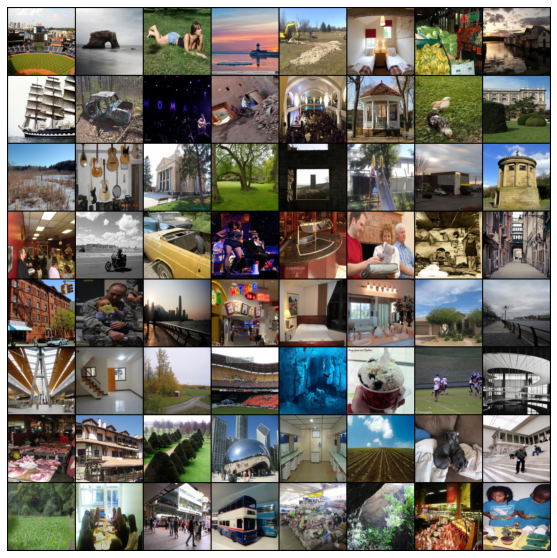

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model_Output


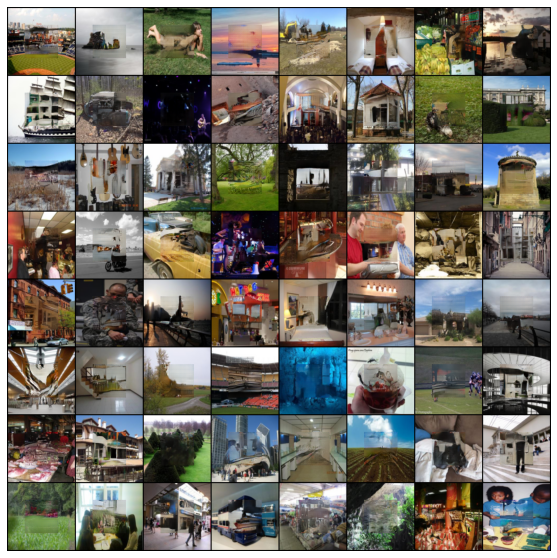

In [22]:
#Evaluate train loader
generator.eval()

masked, true_center, original, label = next(iter(places365_train_loader))

masked = masked.to(device)
model_output = generator(masked)

inpainted_samples = masked.clone().to(device)
inpainted_samples[:,:, 32:96, 32:96] = model_output

# def display_samples(image):
#     npimg = image.numpy()
#     plt.figure(figsize = (10, 10))
#     plt.axis('off')
#     plt.imshow(np.transpose(npimg, (1,2,0)))
#     plt.show()

print('Original Image')
display_samples(torchvision.utils.make_grid(original))
print('Model_Output')
display_samples(torchvision.utils.make_grid(inpainted_samples))

